# Análise Exploratória - Atividades Econômicas Potenciais

## Sobre este notebook

O objetivo deste notebook é fazer um breve resumo sobre a geografia e indicadores sociais do município potencial escolhido e, em seguida realizar uma análise para entender quais produtos agrícolas produzidos atualmente são subexplorados.

Para isso, foi realizada uma análise comparativa entre o município potencial e seus vizinhos, tanto do ponto de vista geográfico quanto ambiental. Após a identificação dos vizinhos, foi feita a comparação entre os produtos agrícolas mais produzidos pelo município potencial e a produção média de seus vizinhos. A partir deste ponto, foi possível identificar os primeiros sinais de subexploração de um produto agrícola.

Dentre os municípios vizinhos identificados, um demonstrou ser uma grande referência local na exploração do produto agrícola potencial identificado. As análises subsequentes tiveram como objetivo validar se o município potencial e o seu vizinho mais notável compartilhavam as mesmas condições ambientais, de modo a validar uma possível replicação da atividade exploratória em seu território.

Por fim, foram feitas análises para validar o potencial de expansão agrícola do município, sua capacidade geológica e climática para plantar o produto potencial e foi feita uma projeção do impacto que essa exploração pode gerar na sociedade.

# 1) Imports

In [1]:
import secrets
import string
import folium
import pandas as pd 
import numpy as np
import warnings
import geopandas as gpd
import joblib as jb
import seaborn as sns
import matplotlib.pyplot as plt
from millify import millify
from shapely import wkt
from shapely.geometry import shape
from geopy.distance import great_circle

warnings.filterwarnings('ignore')

# 2) Funções

In [179]:
def carregar_municipios_sertao():
    all_muns = pd.read_csv(r"../Dados/Tabela_final/municipios_clusters.csv")
    lim_muns = pd.read_json(r'../Dados/Views/municipios-poligonos.json')
    lim_muns['poligono'] = [str(polygon) for polygon in lim_muns['poligono']]
    lim_muns['geometry'] = lim_muns['poligono'].apply(lambda x: shape(eval(x)))
    lim_muns = lim_muns[['municipioCodigo', 'geometry']].rename(columns={'municipioCodigo':'IBGE7'})
    all_muns = all_muns.merge(lim_muns, on = 'IBGE7', how = 'inner')
    all_muns = gpd.GeoDataFrame(all_muns, geometry='geometry')
    all_muns = all_muns.set_crs("EPSG:4326")
    return all_muns

def carregar_agro():
    agro = pd.read_csv(r"../Dados/Tabela_final/dados_producao_agricola.csv").drop(columns='Unnamed: 0')
    agro['VALOR_PROD'] = agro['VALOR_PROD']*1000
    agro['REND_AREA'] = agro['REND_AREA']*1000
    return agro

def carregar_solos(_all_muns):
    solos = pd.read_csv(r"../Dados/Views/solos_municipios.csv").drop(columns='Unnamed: 0')
    solos = _all_muns[['IBGE7', 'NOME']].merge(solos, on = 'IBGE7', how = 'inner').drop(columns='IBGE7')
    solos['AREA_TOTAL'] = round(solos['AREA_TOTAL'],2)
    return solos

def carregar_dados_mapa():
    dados_mapa = pd.read_csv(r"../Dados/Views/dados_mapa.csv")
    lim_muns = pd.read_json(r'../Dados/Views/municipios-poligonos.json')
    lim_muns['poligono'] = [str(polygon) for polygon in lim_muns['poligono']]
    lim_muns['geometry'] = lim_muns['poligono'].apply(lambda x: shape(eval(x)))
    lim_muns = lim_muns[['municipioCodigo', 'geometry']].rename(columns={'municipioCodigo':'IBGE7'})
    dados_mapa = dados_mapa.merge(lim_muns, on = 'IBGE7', how = 'inner')
    dados_mapa = gpd.GeoDataFrame(dados_mapa, geometry='geometry')
    dados_mapa = dados_mapa.set_crs("EPSG:4326")
    return dados_mapa

def carregar_dados_knn():
    dados_knn = pd.read_csv(r"../Dados/Views/dataset_knn_processado.csv")
    return dados_knn

def muns_prox_geo(_mun_df, _all_muns, _raio):
    coordenadas_mun = (_mun_df['LATITUDE'].iloc[0], _mun_df['LONGITUDE'].iloc[0])
    muns_prox = {}
    for _, row in _all_muns[_all_muns['IBGE7']!=_mun_df['IBGE7'].iloc[0]].iterrows():
        coordenadas_muns_prox = (row['LATITUDE'], row['LONGITUDE'])
        distancia = great_circle(coordenadas_mun, coordenadas_muns_prox).kilometers
        if distancia <= _raio:
            muns_prox[row['IBGE7']] = round(distancia,2)
    return muns_prox

def dados_para_plot():
    biomas_municipais = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", 
                                      sheet_name="TRANSICOES_COL8.0")
    biomas_municipais = biomas_municipais[["geocode", "state_acronym", "from_level_2", "to_level_2", "1985-2022"]]
    biomas_municipais.rename(columns={"geocode":"IBGE7", "state_acronym":"UF"}, inplace=True)
    condicao_agricultura = (biomas_municipais["to_level_2"].isin(["Agriculture", "Mosaic of Agriculture and Pasture"]))
    biomas_municipais = biomas_municipais[condicao_agricultura].reset_index(drop=True)
    biomas_municipais_melted = biomas_municipais.melt(id_vars=["UF","IBGE7", "to_level_2", "from_level_2"], 
                                                            value_name="AREA_TRANSICAO",
                                                            value_vars="1985-2022")
    agrupado = biomas_municipais_melted.groupby(by=["UF", "IBGE7", "from_level_2"])[["AREA_TRANSICAO"]].sum()
    agrupado["AREA_TRANSICAO_MEDIA_ANUAL"] = agrupado["AREA_TRANSICAO"] / 38
    dados_biomas = agrupado.reset_index().sort_values(by=["IBGE7", "AREA_TRANSICAO_MEDIA_ANUAL"], ascending=[True, False])
    return dados_biomas


def dados_tendencia_agricultura():    
    biomas_municipais = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", sheet_name="COBERTURA_COL8.0")
    biomas_municipais.drop(columns=["biome [municipality]", "biome", "feature_id", "class_id"], inplace=True)
    biomas_municipais.rename(columns={"geocode":"IBGE7", "municipality":"NOME", "state_acronym":"UF"}, inplace=True)
    biomas_agrupados = biomas_municipais.groupby(["UF","IBGE7", "level_2", "NOME"])[list(range(1985, 2023))].sum().reset_index()
    biomas_agrupados_cidade = biomas_agrupados[(biomas_agrupados["level_2"] == "Agriculture")]
    serie_agricultura = biomas_agrupados_cidade.melt(id_vars=["UF","IBGE7", "level_2", "NOME"], 
                             var_name="ANO", 
                             value_name="AREA_AGRICULTURA")
    serie_agricultura
    return serie_agricultura

def plot_tendencia(dados_tendencia):
    nome = dados_tendencia["NOME"].values[0]
    dados_tendencia.plot(kind="line", x="ANO", y="AREA_AGRICULTURA", color="g")
    plt.title(f"Dinâmica da área da agricultura em {nome}")
    plt.ylabel("Área de agricultura (Ha)");

def dados_para_stacked_plot():
    biomas_municipais = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", 
                                          sheet_name="COBERTURA_COL8.0")
    biomas_municipais.drop(columns=["biome [municipality]", "municipality", "biome", "feature_id", "class_id"], inplace=True)
    biomas_municipais.rename(columns={"geocode":"IBGE7"}, inplace=True)
    biomas_agrupados = biomas_municipais.groupby(["IBGE7", "level_2"])[list(range(1985, 2023))].sum().reset_index()
    
    biomas_lista = ["Forest Formation", "Mosaic of Agriculture and Pasture", "Pasture", "Savanna Formation"]
    lista_Anos = list(range(2010, 2022))
    biomas_serem_explorados = biomas_agrupados[biomas_agrupados["level_2"].isin(biomas_lista)]
    biomas_serem_explorados = biomas_serem_explorados.melt(id_vars=["IBGE7", "level_2"], var_name="ANO", value_name="AREA_HECTAR")
    biomas_serem_explorados = biomas_serem_explorados[biomas_serem_explorados["ANO"].isin(lista_Anos)]
    return biomas_serem_explorados


def plot_stacked_bar(biomas_serem_explorados):
    pivot_df = biomas_serem_explorados.drop(columns="IBGE7").pivot(index='ANO', columns='level_2', values='AREA_HECTAR')
    pivot_df_percent = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
    ax = pivot_df_percent.plot(kind='bar', stacked=True, figsize=(20, 10))
    sns.set_style(None)
    ax.set_xlabel(None)
    plt.ylabel('% de área')
    plt.xticks(rotation=0)
    plt.title('Distribuição das coberturas mais indicadas para transição para Agricultura')
    plt.show()


def muns_prox_knn(dados_knn, model_knn, mun_cod, k):
    mun_df = dados_knn[dados_knn['IBGE7'] == mun_cod].drop(columns=['IBGE7', 'NOME','Unnamed: 0'])
    distances, neighbours = model_knn.kneighbors(mun_df, n_neighbors=k+1)
    distances = distances[0][1:]
    neighbours = neighbours[0][1:]
    muns_prox_cod = [dados_knn['IBGE7'].iloc[n] for n in neighbours]
    muns_prox = {cod:dist for cod, dist in zip(muns_prox_cod, distances)}
    return muns_prox

def comp_dist(all_muns, muns_prox_geo, muns_prox_amb):

    fig, axs = plt.subplots(1, 2, figsize=(15, 8))
    
    geo_nomes = [all_muns[all_muns['IBGE7']==cod]['NOME'].iloc[0] for cod in list(muns_prox_geo.keys())]
    muns_prox_geo_df = pd.DataFrame()
    muns_prox_geo_df['NOME'] = geo_nomes
    muns_prox_geo_df['DIST'] = list(muns_prox_geo.values())
    muns_prox_geo_df = muns_prox_geo_df.sort_values(by='DIST', ascending = True).head(5)
    
    amb_nomes = [all_muns[all_muns['IBGE7']==cod]['NOME'].iloc[0] for cod in list(muns_prox_amb.keys())]
    muns_prox_amb_df = pd.DataFrame()
    muns_prox_amb_df['NOME'] = amb_nomes
    muns_prox_amb_df['DIST'] = list(muns_prox_amb.values())
    muns_prox_amb_df = muns_prox_amb_df.sort_values(by='DIST', ascending = True).head(5)

    sns.barplot(data = muns_prox_geo_df, x='DIST', y='NOME', ax=axs[0], color='skyblue',ci=None)
    sns.despine()
    axs[0].set_ylabel('')
    axs[0].set_xlabel('')
    axs[0].set_title('Municípios de menor distância geográfica (km)')

    sns.barplot(data = muns_prox_amb_df, x='DIST', y='NOME', ax=axs[1], color='skyblue',ci=None)
    sns.despine()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('')
    axs[1].set_title('Municípios de menor distância de cosseno ambiental')
    
    plt.subplots_adjust(hspace=1)
    plt.tight_layout()

    fig.show()

def carregar_mapa(mun_cod):
    
    centroids = dados_mapa[['IBGE7', 'geometry']]
    centroids.crs = 'epsg:32724'
    lat = centroids[centroids['IBGE7'] == mun_cod].centroid.y
    long = centroids[centroids['IBGE7'] == mun_cod].centroid.x
    
    m = folium.Map(location=[lat, long], zoom_start=8.5)
    
    folium.Marker(
        location=[
            centroids[centroids['IBGE7'] == mun_cod].centroid.y,
            centroids[centroids['IBGE7'] == mun_cod].centroid.x
        ],
        icon=folium.Icon(color='red')
    ).add_to(m)
    
    return centroids, m

def filters_and_markers(centroids, m, neighs, alias):
    
    metric = aliases[alias]

    neighs = list(set(centroids['IBGE7']) & set(neighs))
    
    for n in neighs:
        folium.Marker(
            location=[
                centroids[centroids['IBGE7'] == n].centroid.y,
                centroids[centroids['IBGE7'] == n].centroid.x
            ],
            icon=folium.Icon(color='blue')
        ).add_to(m)


    colormap = branca.colormap.LinearColormap(
        vmin=dados_mapa[metric].quantile(0.0),
        vmax=dados_mapa[metric].quantile(1),
        colors=[
            "red",
            "orange",
            "yellow",
            "green",
            "blue",
            "purple"
        ],
        caption=alias
    )

    tooltip = folium.GeoJsonTooltip(
        fields=["IBGE7", "NOME", metric],
        aliases=["Código do IBGE:", "Nome:", f"{alias}:"],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
        """,
        max_width=800
    )
    gjson = folium.GeoJson(
        dados_mapa,
        style_function=lambda x: {
            "fillColor": colormap(x["properties"][metric])
            if x["properties"][metric] is not None
            else "transparent",
            "color": "black",
            "fillOpacity": 0.4,
        },
        tooltip=tooltip,
    ).add_to(m)
    colormap.add_to(m)
    
    return m

def comp_df(_metric, _mun_df, _all_muns, _muns_prox_cod):
    mun_metric = _mun_df[_metric].iloc[0]
    muns_prox_df = _all_muns[_metric].loc[_all_muns['IBGE7'].isin(_muns_prox_cod)].mean()
    comp_df = pd.DataFrame()
    comp_df.insert(0, 'NOME', ['Município Potencial', 'Média do(s) Vizinho(s)'])
    comp_df.insert(1, _metric, [round(mun_metric,1), round(muns_prox_df,1)])
    return comp_df

def comp_agro(metric, mun_cod, geo, amb):
    
    def formatar_valor_millify(x, pos):
        return millify(x, precision=1)

    mun_df = agro[agro['IBGE7'] == mun_cod].sort_values(by=metric, ascending=False)
    
    geo_df = agro[agro['IBGE7'].isin(geo)]
    geo_df = geo_df[['PRODUTO', metric]].groupby('PRODUTO').mean().reset_index().sort_values(by=metric, ascending=False)
    
    amb_df = agro[agro['IBGE7'].isin(amb)]
    amb_df = amb_df[['PRODUTO', metric]].groupby('PRODUTO').mean().reset_index().sort_values(by=metric, ascending=False)
    
    v1 = 'Vizinhos Geográficos - Média'
    v2 = 'Vizinhos Ambientais - Média'
    
    if metric == 'VALOR_PROD':
        title = 'Produtos agrícolas mais comercializados'
        text = "Valor comercializado (reais)"
    elif metric == 'AREA_PLANTADA':
        title = 'Produtos agrícolas com maior área plantada'
        text = "Área plantada (ha)"
    elif metric == 'REND_AREA':
        title = 'Produtos agrícolas com maior faturamento por área plantada'
        text = "Valor comercializado (reais) / Área plantada (ha)"
    elif metric == 'REND_MEDIO':
        title = 'Produtos agrícolas com maior rendimento por área plantada'
        text = "Total produzido (kg) / Área plantada (ha)"

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    sns.barplot(mun_df, x=metric, y='PRODUTO', ax=axs[0],color='skyblue',ci=None)
    sns.despine()
    axs[0].set_xlabel(text)
    axs[0].set_ylabel('Produtos')
    axs[0].set_title('Município Potencial')
    axs[0].set_xticklabels([millify(x, precision=2) for x in axs[0].get_xticks()])

    sns.barplot(geo_df, x=metric, y='PRODUTO', ax=axs[1],color='skyblue',ci=None)
    sns.despine()
    axs[1].set_xlabel(text)
    axs[1].set_ylabel('Produtos')
    axs[1].set_title(v1)
    axs[1].set_xticklabels([millify(x, precision=2) for x in axs[1].get_xticks()])

    sns.barplot(amb_df, x=metric, y='PRODUTO', ax=axs[2],color='skyblue',ci=None)
    sns.despine()
    axs[2].set_xlabel(text)
    axs[2].set_ylabel('Produtos')
    axs[2].set_title(v2)
    axs[2].set_xticklabels([millify(x, precision=2) for x in axs[2].get_xticks()])

    plt.tight_layout()

    plt.show()


def bar_plot(df, x, y, title):
    df = df.sort_values(by=y)
    fig = sns.barplot(
        df, 
        x=x, 
        y=y,
        color='skyblue'
        )
    sns.despine()
    fig.set_title(title)
    fig.set_ylabel('Produtos')
    fig.set_xlabel('')
    plt.tight_layout()
    plt.show()

    
def comp_solos():
    
    solos_mun = solos[['SOLO', 'AREA_TOTAL']].loc[solos['NOME']=='ITAPICURU'].sort_values(by='AREA_TOTAL',ascending = False)
    solos_prox = solos[solos['NOME'].isin(list(['RIBEIRA DO AMPARO']))]
    solos_prox = solos_prox[['SOLO', 'AREA_TOTAL']].groupby('SOLO').sum().reset_index().sort_values(by='AREA_TOTAL',ascending = False)

    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.barplot(solos_mun, x='AREA_TOTAL', y='SOLO', ax=axs[0],color='skyblue',ci=None)
    sns.despine()
    axs[0].set_xlabel('Área total (ha)')
    axs[0].set_ylabel('')
    axs[0].set_title('Município Potencial')
    axs[0].set_xticklabels([millify(x, precision=2) for x in axs[0].get_xticks()])

    sns.barplot(solos_prox, x='AREA_TOTAL', y='SOLO', ax=axs[1],color='skyblue',ci=None)
    sns.despine()
    axs[1].set_xlabel('Área total (ha)')
    axs[1].set_ylabel('')
    axs[1].set_title('Média do(s) Vizinho(s)')
    axs[1].set_xticklabels([millify(x, precision=2) for x in axs[1].get_xticks()])
    
    plt.subplots_adjust(hspace=1)
    plt.tight_layout()

    fig.show()
    
def comp_econom(metric):

    produtos = ['CASTANHA DE CAJU', 'MELAO', 'PIMENTA-DO-REINO']
    df = agro[agro['PRODUTO'].isin(produtos)]

    if metric == 'VALOR_PROD':
        df = df[['ANO', 'PRODUTO', metric]].groupby(['ANO', 'PRODUTO']).sum().reset_index()
        title = "Total comercializado de cada produto entre 2020 e 2022 no Sertão"
        y_axis = "Valor produzido (reais)"
    else:
        df = df[['ANO', 'PRODUTO', metric]].groupby(['ANO', 'PRODUTO']).mean().reset_index()
        title = "Rentabilidade por hectare de cada produto agrícola entre 2020 e 2022"
        y_axis = "Valor produzido (reais) / Área plantada (ha)"

    df['ANO'] = df['ANO'].astype('str')
    nova_ordem = ['MELAO', 'CASTANHA DE CAJU', 'PIMENTA-DO-REINO']
    df['PRODUTO'] = pd.Categorical(df['PRODUTO'], categories=nova_ordem, ordered=True)

    #cores = ["#1d8e42","#666666", "#cccccc"]
    fig = sns.lineplot(data=df, x="ANO", y=metric, hue = 'PRODUTO', ci = None, markers=True)
    sns.despine()
    plt.title(title)
    plt.xlabel("Ano")
    plt.ylabel(y_axis)
    sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1), title=None, frameon=False)
    plt.show()
    
    
def produtos_comp_area_rend():
    base_size = 400
    produtos = ['CASTANHA DE CAJU', 'MELAO']
    df = agro[agro['PRODUTO'].isin(produtos)]
    df = df[['PRODUTO', 'AREA_PLANTADA', 'VALOR_PROD']].groupby(['PRODUTO']).sum().reset_index()
    df['REND_AREA'] = df['VALOR_PROD']/df['AREA_PLANTADA']

    colors = []
    fig = sns.scatterplot(
        data=df, 
        x='AREA_PLANTADA', 
        y='REND_AREA', 
        size='VALOR_PROD', 
        hue='PRODUTO', 
        sizes=(base_size, base_size*10),
        #palette = ['#666666', '#1d8e42', '#999999']
    )
    sns.despine()

    plt.xlabel('Área plantada (ha)')
    plt.ylabel('Rendimento Médio por Hectare (R$/ha)')
    plt.title("Área total plantada X Rendimento médio por área entre 2020 e 2022")

    fig.set_xticklabels([millify(x, precision=2) for x in fig.get_xticks()])
    fig.set_yticklabels([millify(y, precision=2) for y in fig.get_yticks()])

    fig.set_ylim(-2000, 35000)
    fig.set_xlim(-80000, 1500000)

    plt.legend().remove()

    plt.tight_layout()
    plt.show()
    
def produtos_comp_valor_prod():
    
    produtos = ['CASTANHA DE CAJU', 'MELAO']
    df = agro[agro['PRODUTO'].isin(produtos)]
    df = df[['PRODUTO', 'ANO', 'VALOR_PROD']].groupby(['PRODUTO','ANO']).sum().reset_index()
    df['ANO'] = df['ANO'].astype('str')

    colors = []
    fig = sns.lineplot(
        data=df, 
        x='ANO', 
        y='VALOR_PROD', 
        hue='PRODUTO', 
        markers = True
        #palette = ['#666666', '#1d8e42', '#999999']
    )
    sns.despine()

    plt.xlabel('')
    plt.ylabel('Valor comercializado (reais)')
    plt.title("Valor comercializado de cada produto por ano")

    fig.set_yticklabels([millify(y, precision=2) for y in fig.get_yticks()])

    #plt.legend().remove()

    plt.tight_layout()
    plt.show()

# 2) Coleta dos dados

In [3]:
all_muns = carregar_municipios_sertao().drop(columns='Unnamed: 0')
agro = carregar_agro()
solos = carregar_solos(all_muns)
dados_barplot = dados_para_plot()
dados_tendencia_agricola = dados_tendencia_agricultura()
dados_stacked = dados_para_stacked_plot()

# 3) Análise dos dados

O município selecionado para a análise foi **Itapicuru-BA**. Dentre os fatores sociais que mais foram levados em consideração, destaca-se o seu IDH, que é o menor do seu cluster.

## 3.1) Informações geográficas

In [4]:
# Código do IBGE para o município de Itapicuru
mun_cod = 2916500
mun_df = all_muns[all_muns['IBGE7']==mun_cod]
nome = mun_df['NOME'].iloc[0]
uf = mun_df['UF'].iloc[0]
capital_prox = mun_df['CAPITAL_PROX'].iloc[0]
pop_tot = millify(mun_df['POP_TOT'], precision=1, drop_nulls=False)
pop_tot_30 = millify(mun_df['POP_TOT_30KM'], precision=1, drop_nulls=False)
dist_capital = millify(mun_df['DIST_CAPITAL'], precision=0, drop_nulls=False)
custo_transporte = millify(mun_df['TRANSPORT_COST'], precision=2, drop_nulls=False)
print('NOME:',nome)
print('UF:',uf)
print('Capital mais próxima:', capital_prox)
print('População:',pop_tot)
print('População em um raio de 30Km:',pop_tot_30)
print('Distância até a capital mais próxima:',dist_capital)
print('Custo de transporte para o porto mais próximo:',custo_transporte)

NOME: ITAPICURU
UF: BA
Capital mais próxima: ARACAJU
População: 35.9k
População em um raio de 30Km: 197.8k
Distância até a capital mais próxima: 134
Custo de transporte para o porto mais próximo: 23.77k


## 3.2) Dados socioeconômicos

In [5]:
idh = millify(mun_df['IDHM'], precision=3, drop_nulls=False)
renda = millify(float(mun_df['RDPC']), precision=2, drop_nulls=False)
i_freq = round(float(mun_df['I_FREQ_PROP'])*100,2)
t_analf = round(float(mun_df['T_ANALF15M']),2)
desocup = float(mun_df['T_DES18M'])
pind = float(mun_df['PIND'])
print('IDH:', idh)
print('Renda per capita:', f"R$ {renda}")
print('Subíndice de frequência escolar:', f"{i_freq} %")
print('Taxa de analfabetismo (acima de 15 anos):', f"{t_analf} %")
print('Taxa de desocupação (acima de 18 anos):', f"{desocup} %")
print('Percentual de extramemente pobres:', f"{pind} %")

IDH: 0.486
Renda per capita: R$ 6.36k
Subíndice de frequência escolar: 46.2 %
Taxa de analfabetismo (acima de 15 anos): 38.52 %
Taxa de desocupação (acima de 18 anos): 9.86 %
Percentual de extramemente pobres: 31.44 %


## 3.3) Análise comparativa

Foi criada uma função que calcula os municípios que se encontram **em um raio de 50km** de Itapicuru

In [6]:
raio = 50
geo = muns_prox_geo(mun_df, all_muns, raio)
geo_nomes = all_muns[all_muns['IBGE7'].isin(list(geo.keys()))]['NOME'].values
geo_nomes

array(['CIPO', 'CRISOPOLIS', 'NOVA SOURE', 'OLINDINA',
       'RIBEIRA DO AMPARO', 'TOBIAS BARRETO'], dtype=object)

In [122]:
geo.keys()

dict_keys([2907905, 2909604, 2922904, 2923100, 2926509, 2807402])

Também foi criada uma função que utiliza o algoritmo KNN para calcular os **cinco municípios vizinhos mais próximos de Itapicuru do ponto de vista ambiental**. As variáveis utilizadas para esse cálculo incluem dados como temperatura, precipitação média anual, umidade, percentual de água do solo, qualidade média da água, tipos de solo mais comuns entre outras. Mais informações sobre como esse modelo foi desenvolvido podem ser vistas no notebook Modelagem.

In [7]:
dados_knn = carregar_dados_knn()
model_knn = jb.load(r"C:/Users/User/Documents/GitHub/BCG2023/Dashboards/models/knn.pkl", mmap_mode="r")
k = 5
amb = muns_prox_knn(dados_knn, model_knn, mun_cod, k)
amb_nomes = all_muns[all_muns['IBGE7'].isin(list(amb.keys()))]['NOME'].values
amb_nomes

array(['AGUA FRIA', 'RIBEIRA DO AMPARO', 'RIBEIRA DO POMBAL', 'ACARAU',
       'ITAOBIM'], dtype=object)

Nesta primeira análise, podemos identificar que **Ribeira do Pombal** aparece como vizinho mais próximo em ambos os critérios, dando a entender que ele é bastante similar a Itapicuru.

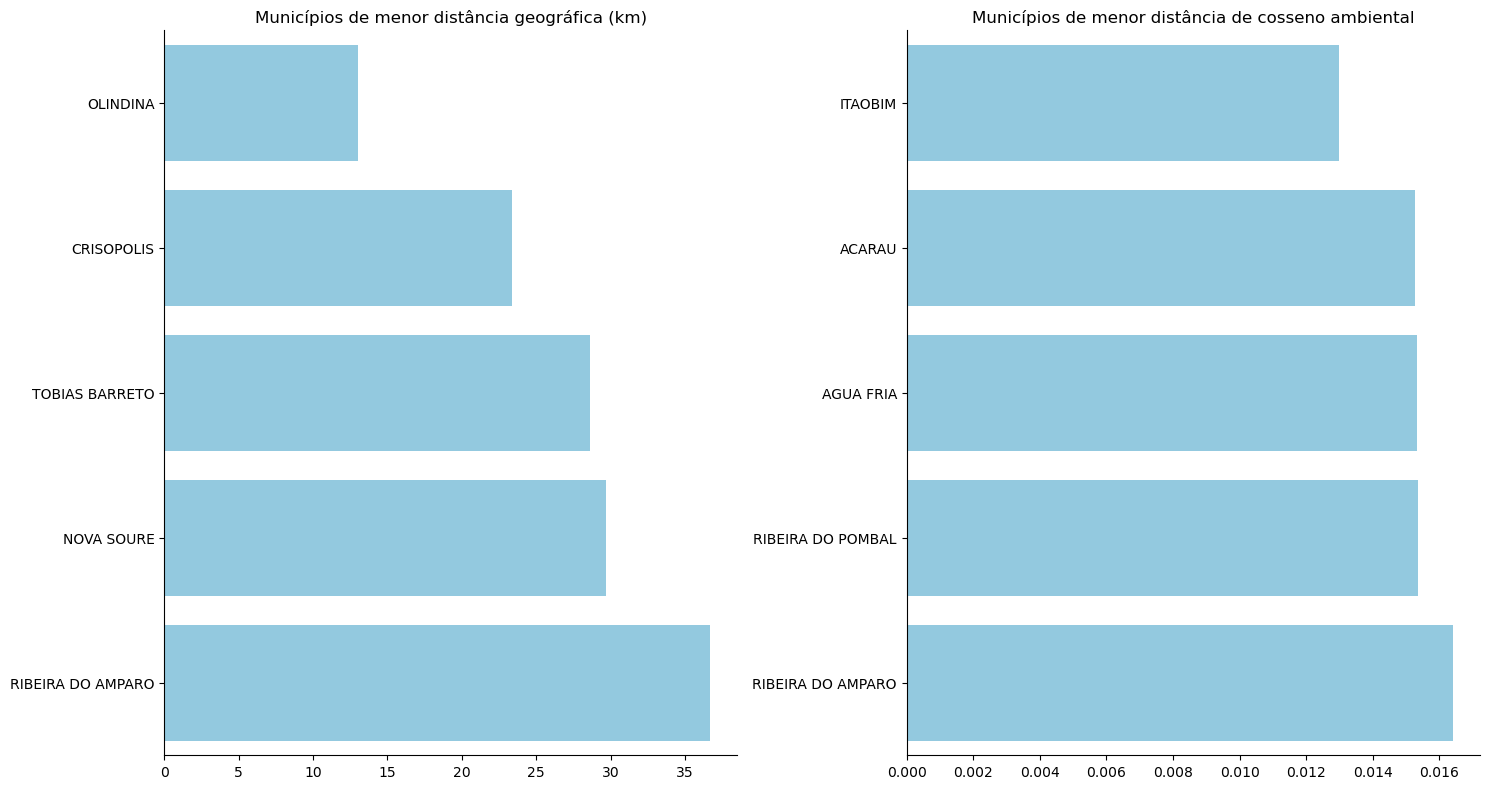

In [43]:
comp_dist(all_muns, geo, amb)

### 3.3.2) Produção agrícola

Foram criados gráficos para visualizar os produtos agrícolas mais explorados entre Itapicuru e seus vizinhos geográficos e ambientais. Os principais pontos identificados nessa análise incluem:

- O melão é apenas o terceiro produto mais comercializado por Itapicuru, porém é o maior entre seus vizinhos tanto geográficos quanto ambientais

- Apesar do milho ser um produto de grande área plantada, sua rentabilidade por hectare é muito baixa.

- O melão aparece frequentemente como sendo um dos produtos de maior rentabilidade por area plantada.

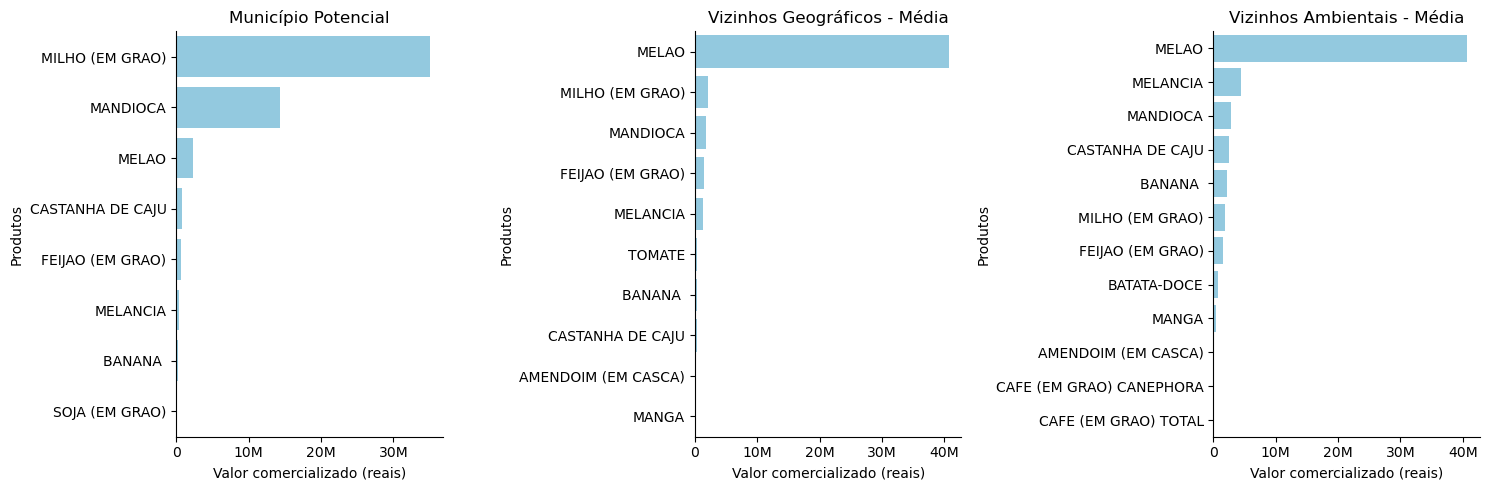

In [48]:
comp_agro('VALOR_PROD', mun_cod, geo, amb)

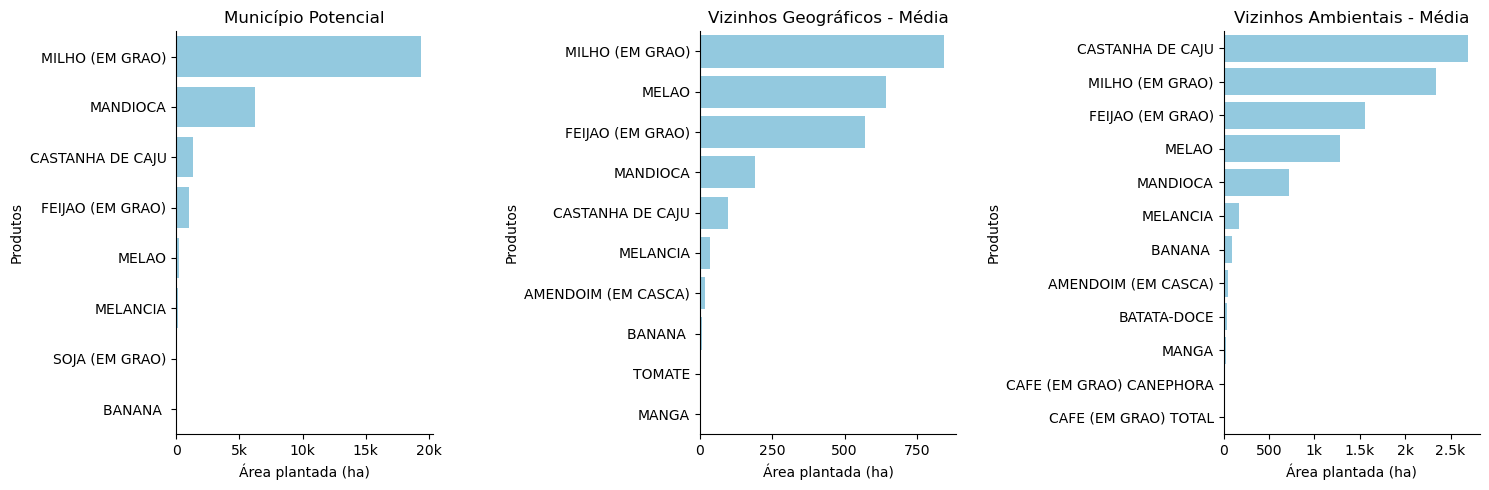

In [49]:
comp_agro('AREA_PLANTADA', mun_cod, geo, amb)

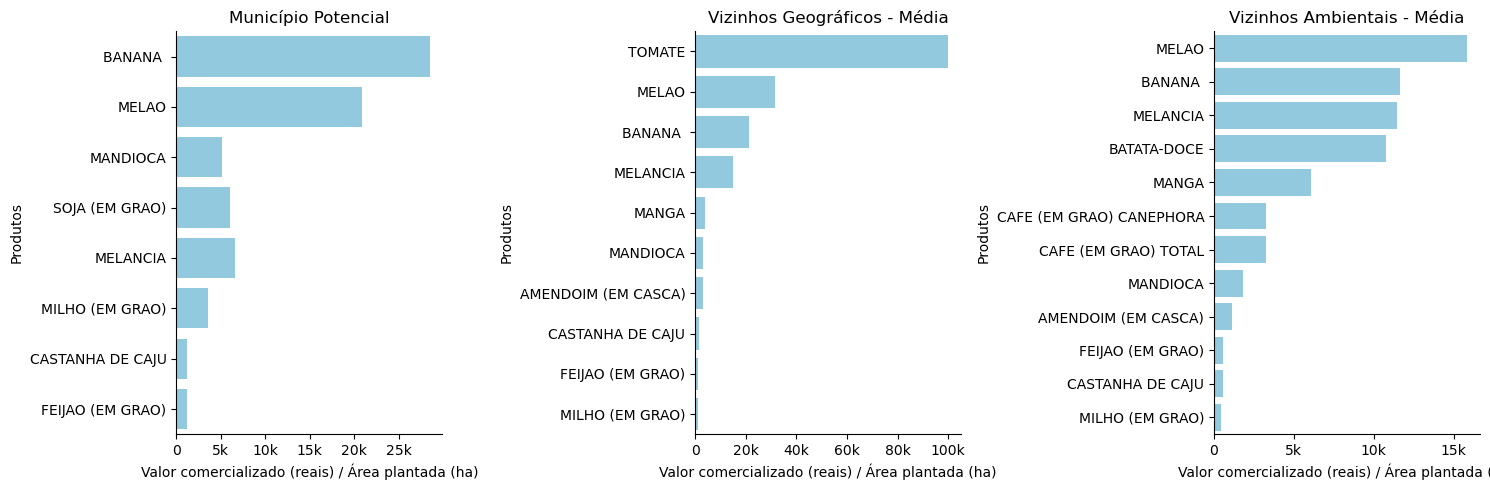

In [50]:
comp_agro('REND_AREA', mun_cod, geo, amb)

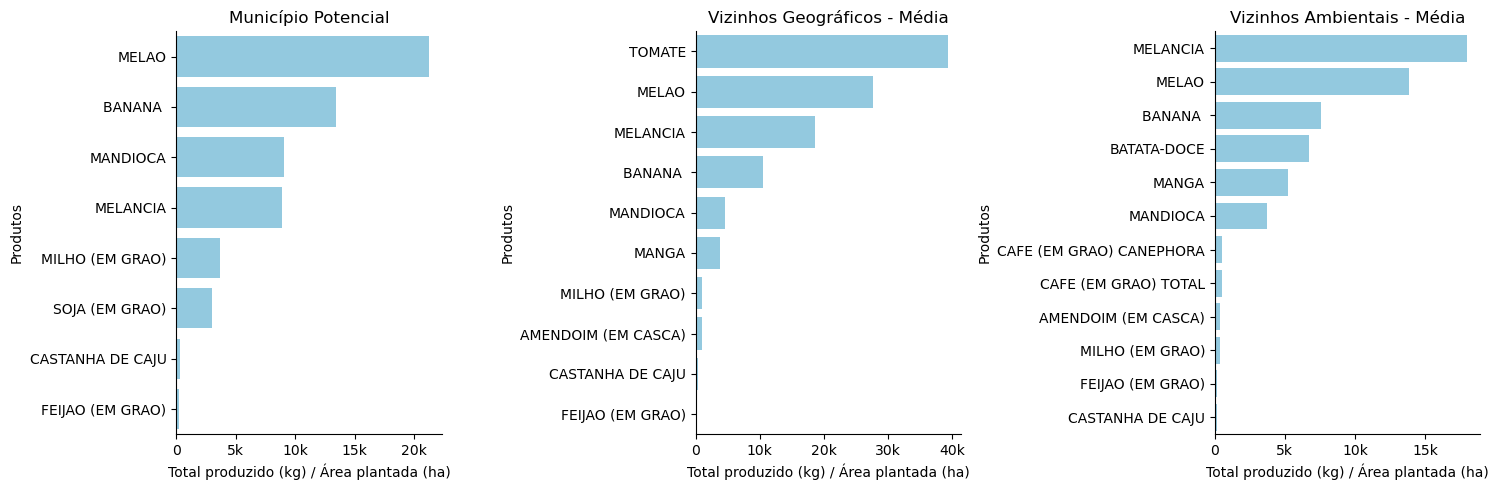

In [51]:
comp_agro('REND_MEDIO', mun_cod, geo, amb)

### 3.3.3) Identificação dos maiores produtores de melão

Dado que o melão mostrou ser um produto bem explorado pelos municípios vizinhos e com uma boa rentabilidade, há indicadores de que este pode ser um produto com potencial de exploração em Itapicuru. Logo, foi feita uma investigação para identificar quais são os principais produtores deste fruto no Sertão.

O gráfico abaixo mostra que **Ribeira do Pombal** é o quarto maior produtor de melão do Sertão entre 2020 e 2022. Além de ser um município similar tanto geograficamente quanto ambiental, ele também é referência na produção do produto com maior potencial de exploração identificado.

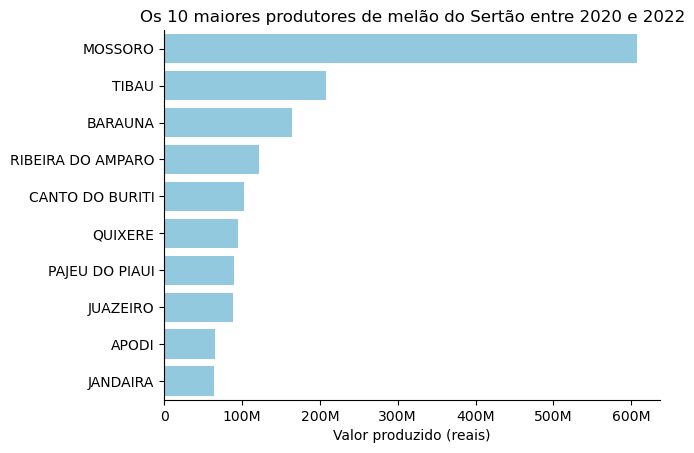

In [53]:
maiores_prod = agro[agro['PRODUTO']=='MELAO'][['NOME', 'VALOR_PROD']]
maiores_prod = maiores_prod.groupby('NOME').sum().reset_index().sort_values(by='VALOR_PROD', ascending = False)
fig = sns.barplot(maiores_prod.head(10), x = 'VALOR_PROD', y = 'NOME',color='skyblue',ci=None)
fig.set_xticklabels([millify(x, precision=2) for x in fig.get_xticks()])
plt.title("Os 10 maiores produtores de melão do Sertão entre 2020 e 2022")
plt.xlabel("Valor produzido (reais)")
plt.ylabel("")
sns.despine()
plt.show()

### 3.3.4) Comparação Itapicuru vs Ribeira do Amparo

Como segundo, passo, foi realizado um estudo para comparar as métricas ambientais entre ambos os municípios, a fim de avaliar se Itapicuru oferece condições necessárias para reproduzir a exploração de melão de sucesso de Ribeira do Amparo em seu território.

A partir dos gráficos a seguir, podemos chegar às seguintes conclusões:
- Itapicuru e Ribeira do Amparo possuem condições climáticas idênticas
- A qualidade média da água de Ribeira do Amparo e sua área irrigada atual são maiores, porém Itapicuru possui percentual de água no solo maior e mais área adicional irrigada potencial efetiva. 
- Ambos compartilham os mesmos tipos de solo, sendo o tipo mais abundante de um também o do outro.

#### 3.3.4.1) Clima

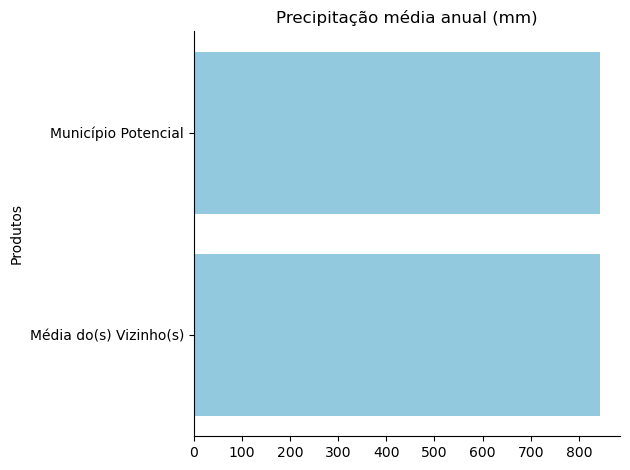

In [14]:
mun_prox_cod = [2926509] # Código de Ribeira do Amparo

bar_plot(
        df = comp_df('PREC_MED', mun_df, all_muns, mun_prox_cod), 
        x = 'PREC_MED', 
        y = 'NOME', 
        title = 'Precipitação média anual (mm)'
        )

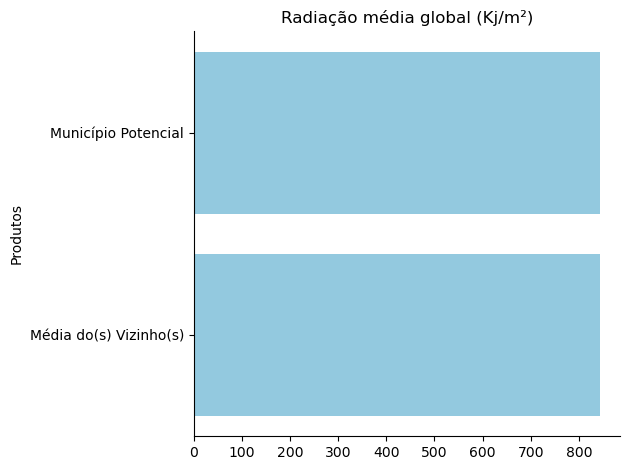

In [15]:
bar_plot(
        df = comp_df('PREC_MED', mun_df, all_muns, mun_prox_cod), 
        x = 'PREC_MED', 
        y = 'NOME', 
        title = 'Radiação média global (Kj/m²)'
        )

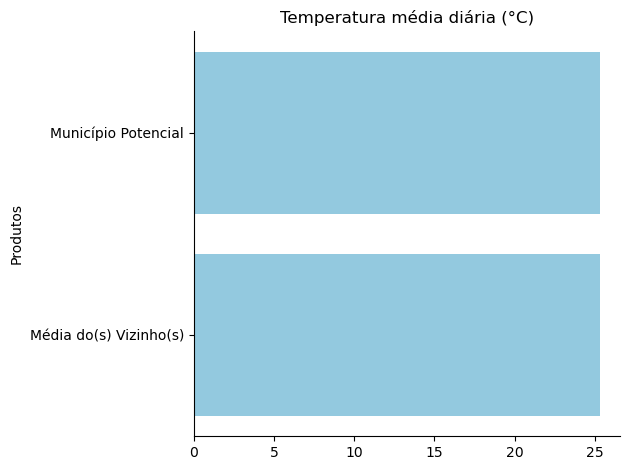

In [16]:
bar_plot(
        df = comp_df('TEMP_MED', mun_df, all_muns, mun_prox_cod), 
        x = 'TEMP_MED', 
        y = 'NOME', 
        title = "Temperatura média diária (°C)"
        )

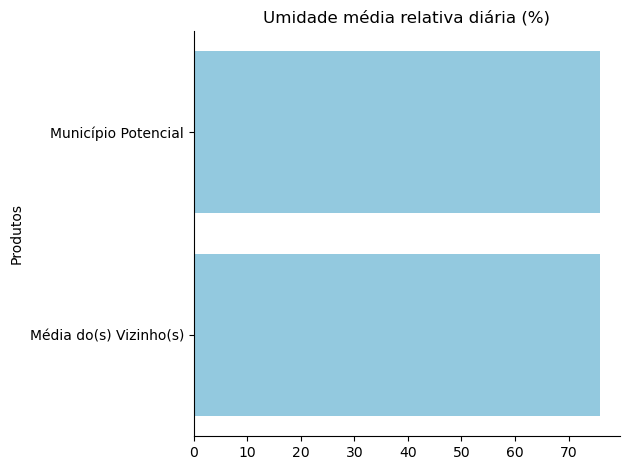

In [17]:
bar_plot(
        df = comp_df('UMI_MED', mun_df, all_muns, mun_prox_cod), 
        x = 'UMI_MED', 
        y = 'NOME', 
        title = "Umidade média relativa diária (%)"
        )

#### 3.3.4.3) Recursos hídricos

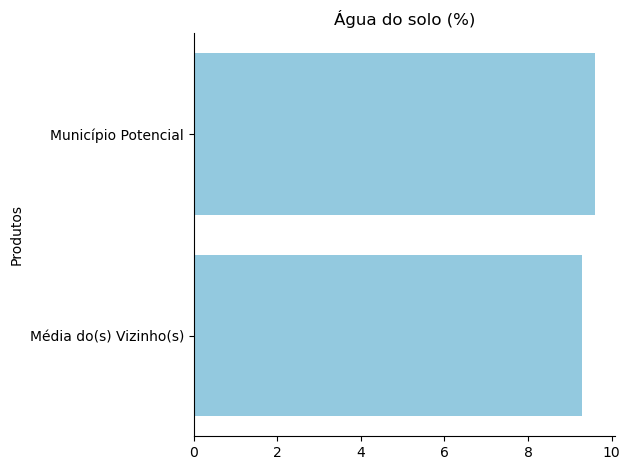

In [18]:
bar_plot(
        df = comp_df('AGUA_SOLO', mun_df, all_muns, mun_prox_cod), 
        x = 'AGUA_SOLO', 
        y = 'NOME', 
        title = "Água do solo (%)"
        )

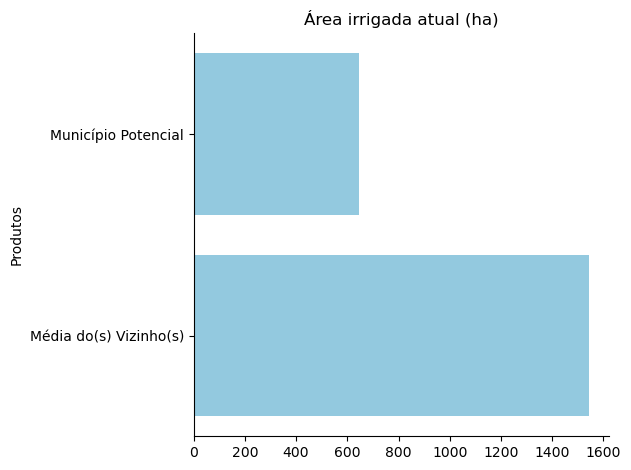

In [19]:
bar_plot(
        df = comp_df('AREA_IRRIGADA_TOT', mun_df, all_muns, mun_prox_cod), 
        x = 'AREA_IRRIGADA_TOT', 
        y = 'NOME', 
        title = "Área irrigada atual (ha)"
        )

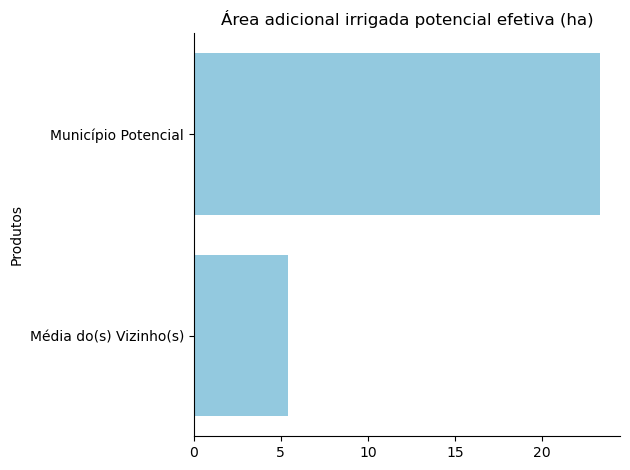

In [20]:
bar_plot(
        df = comp_df('AREA_IRRIGADA_POT_E', mun_df, all_muns, mun_prox_cod), 
        x = 'AREA_IRRIGADA_POT_E', 
        y = 'NOME', 
        title = "Área adicional irrigada potencial efetiva (ha)"
        )

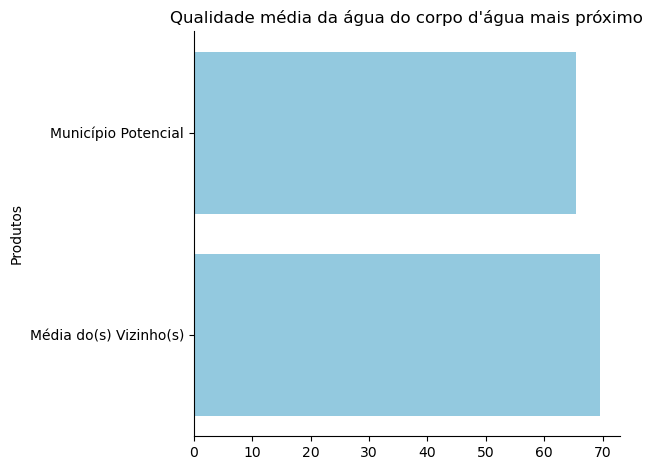

In [21]:
bar_plot(
        df = comp_df('QUAL_MED_AGUA', mun_df, all_muns, mun_prox_cod), 
        x = 'QUAL_MED_AGUA', 
        y = 'NOME', 
        title = "Qualidade média da água do corpo d'água mais próximo"
        )

#### 3.3.4.3) Tipos de solos mais comuns

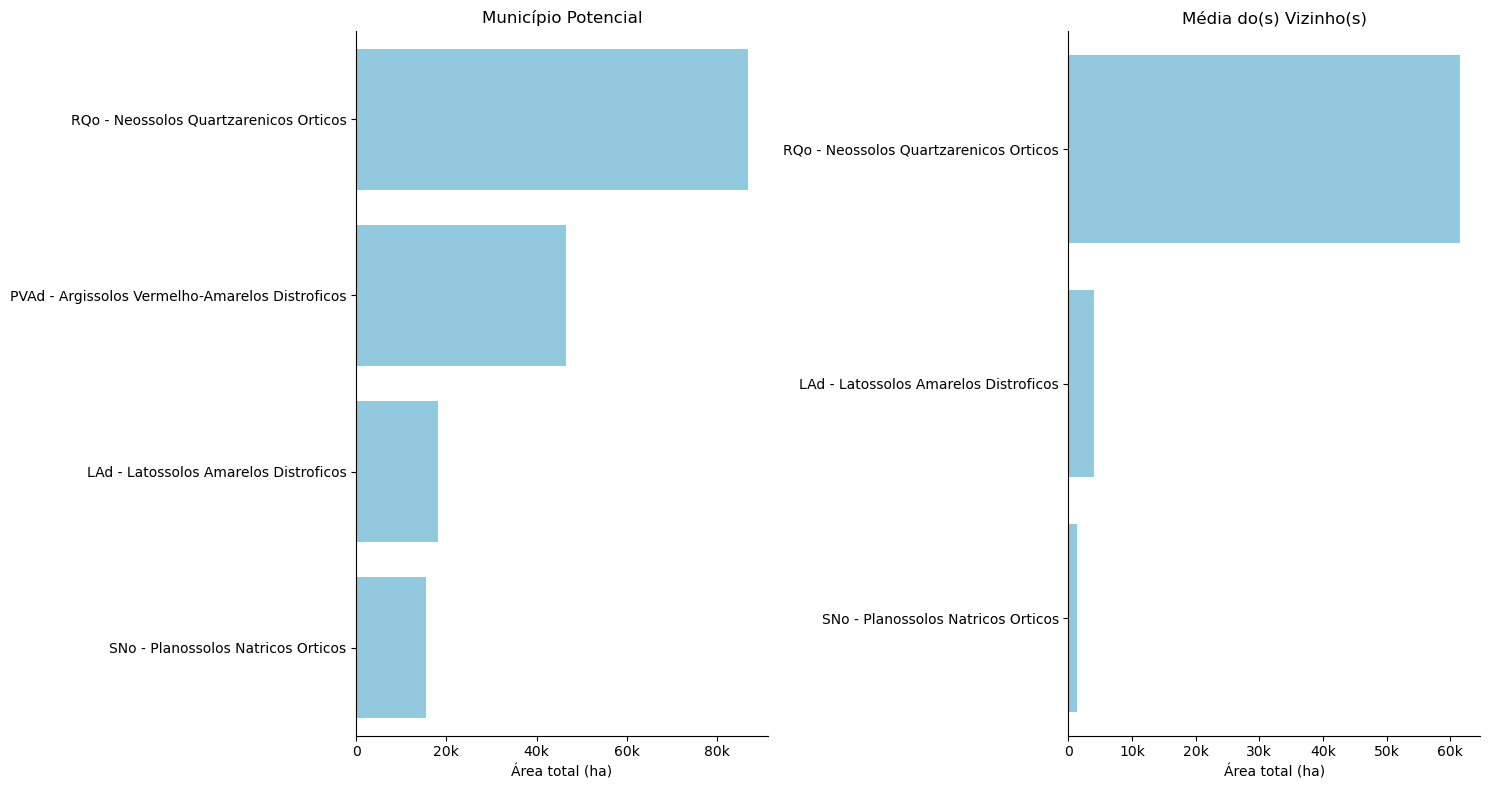

In [55]:
comp_solos()

# 4) Avaliação das vantagens econômicas da exploração do Melão

Dado que Itapicuru e Ribeira do Apresentam muitas características ambientais em comum, o próximo passo consiste em avaliar as vantagens econômicas da exploração de melão em relação aos outros produtos explorados pela Amigos do Bem.

O gráfico abaixo mostra claro que o **melão (em laranja) teve uma menor área plantada entre 2020 e 2022, porém apresentou uma rentabilidade por área muito maior do que a castanha de caju (em azul)**. A diferença foi tão significativa que o valor produzido do melão foi superior ao da castanha de caju nesse período.

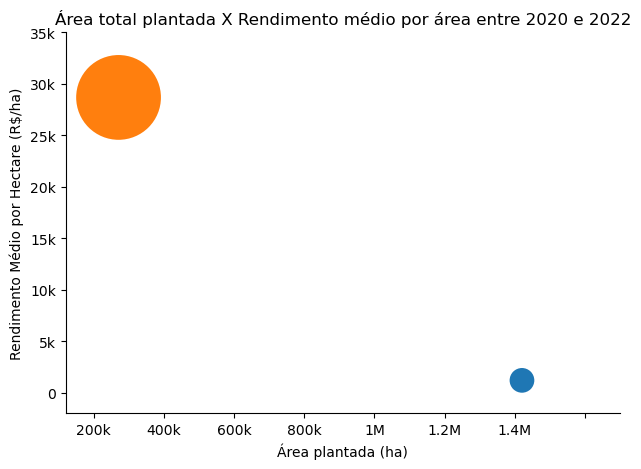

In [80]:
produtos_comp_area_rend()

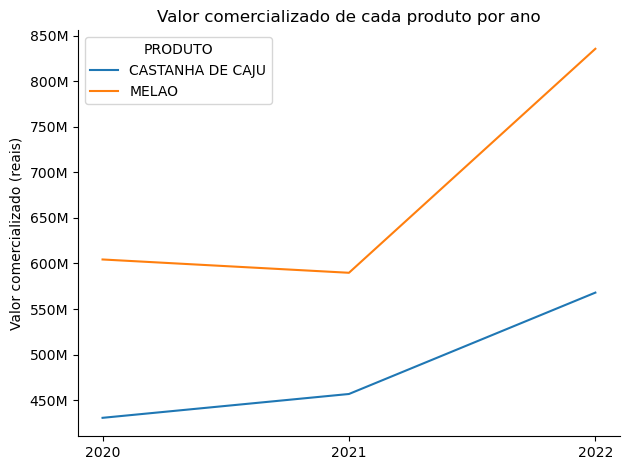

In [180]:
produtos_comp_valor_prod()

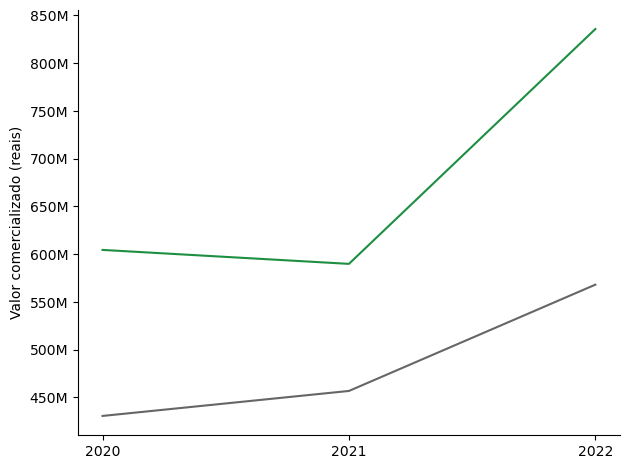

In [188]:
produtos_comp_valor_prod()